In [1]:
# dependencies import
from common_dependencies import *
logger = logging.getLogger('main.model_test')

2024-05-15 21:51:21.028391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# paths for files with original data
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)
PATH_TO_MODEL = 'networks/CNN'
RUNS = [1,2]
MODEL_VER = '14'
OLD_MODEL_NUM = '03'
NEW_MODEL_NUM = '04'
XSHIFT = 200

In [6]:
old_learn_df = pd.read_excel(f"networks/CNN/checkpoints/model_id=v{MODEL_VER}n{OLD_MODEL_NUM}/learning_df.xlsx", index_col=0)
new_learn_df = pd.read_excel(f"networks/CNN/checkpoints/model_id=v{MODEL_VER}n{NEW_MODEL_NUM}/learning_df.xlsx", index_col=0)

learn_df = pd.concat([old_learn_df, new_learn_df])
display(learn_df)

,AUC,BinaryAccuracy,FalseNegatives,FalsePositives,MeanSquaredError,Precision,Recall,TrueNegatives,TruePositives,loss,...,val_BinaryAccuracy,val_FalseNegatives,val_FalsePositives,val_MeanSquaredError,val_Precision,val_Recall,val_TrueNegatives,val_TruePositives,val_loss,learning_rate
0,0.655410,0.762356,5329,18,0.171080,0.538462,0.003925,17132,21,0.519125,...,0.934011,1493,0,0.064254,0.000000,0.000000,21132,0,0.253686,5.000000e-03
1,0.760869,0.774000,4204,881,0.153509,0.565368,0.214206,16269,1146,0.467149,...,0.938298,1351,45,0.063178,0.759358,0.095111,21087,142,0.254012,5.000000e-03
2,0.801284,0.785022,3548,1289,0.143673,0.582983,0.336822,15861,1802,0.437749,...,0.943558,1172,105,0.054683,0.753521,0.215003,21027,321,0.220336,5.000000e-03
3,0.827327,0.795733,2939,1657,0.136154,0.592675,0.450654,15493,2411,0.414651,...,0.946387,1058,155,0.051856,0.737288,0.291360,20977,435,0.207318,5.000000e-03
4,0.849445,0.808933,2485,1814,0.128229,0.612310,0.535514,15336,2865,0.392783,...,0.947624,1022,163,0.043023,0.742902,0.315472,20969,471,0.164718,5.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.976029,0.927244,719,918,0.051866,0.834565,0.865608,16232,4631,0.166428,...,0.955890,837,161,0.033012,0.802938,0.439384,20971,656,0.108887,5.811306e-13
76,0.975912,0.929822,665,914,0.051790,0.836757,0.875701,16236,4685,0.166536,...,0.955890,837,161,0.033012,0.802938,0.439384,20971,656,0.108887,1.743392e-13
77,0.974431,0.925644,732,941,0.053484,0.830725,0.863178,16209,4618,0.171133,...,0.955890,837,161,0.033012,0.802938,0.439384,20971,656,0.108887,1.743392e-13
78,0.975627,0.926444,715,940,0.052036,0.831390,0.866355,16210,4635,0.167930,...,0.955890,837,161,0.033012,0.802938,0.439384,20971,656,0.108887,5.230176e-14


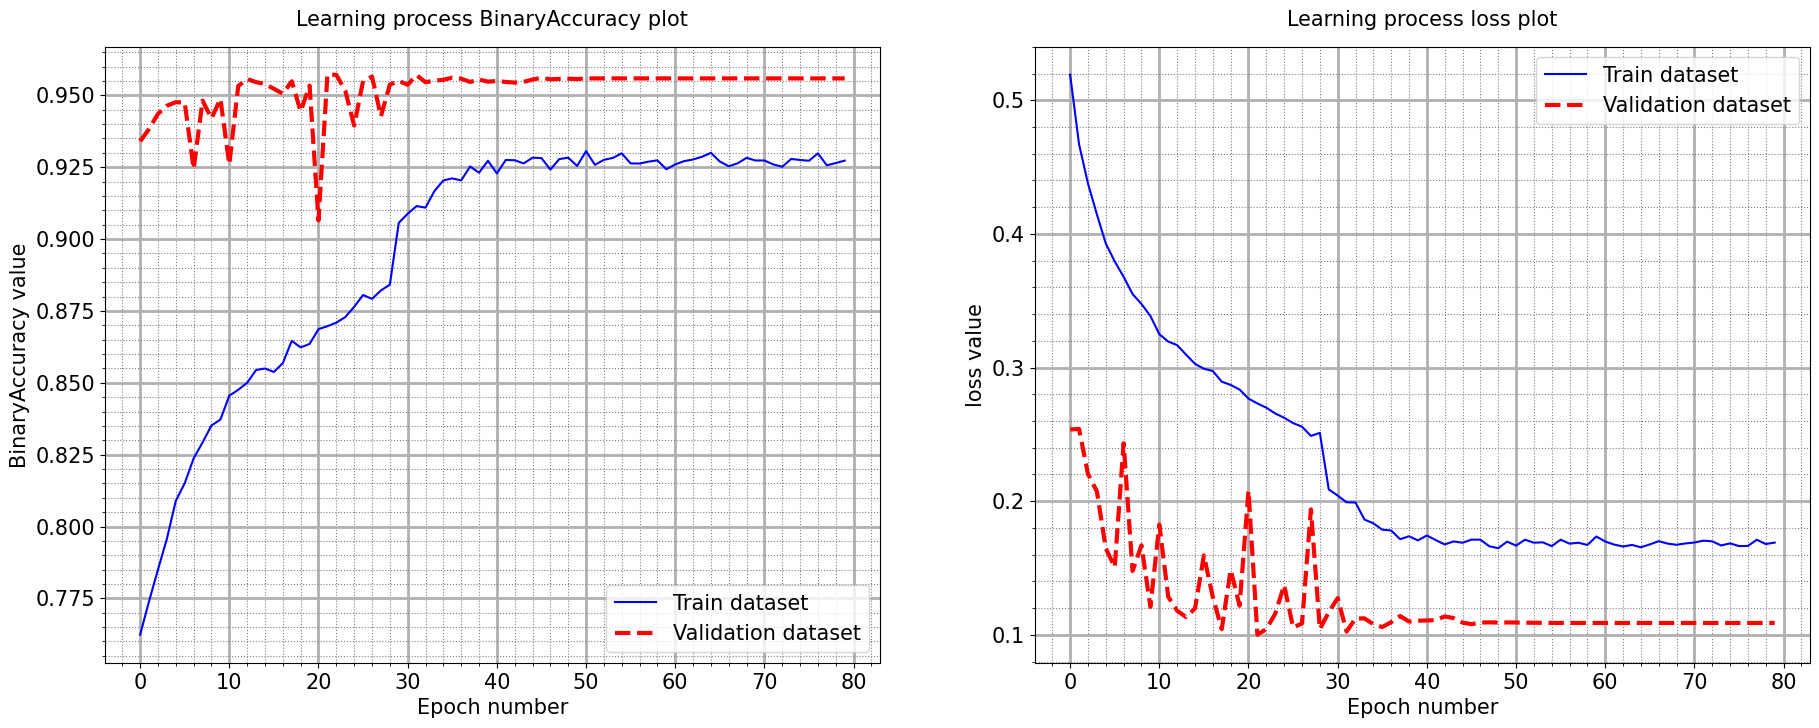

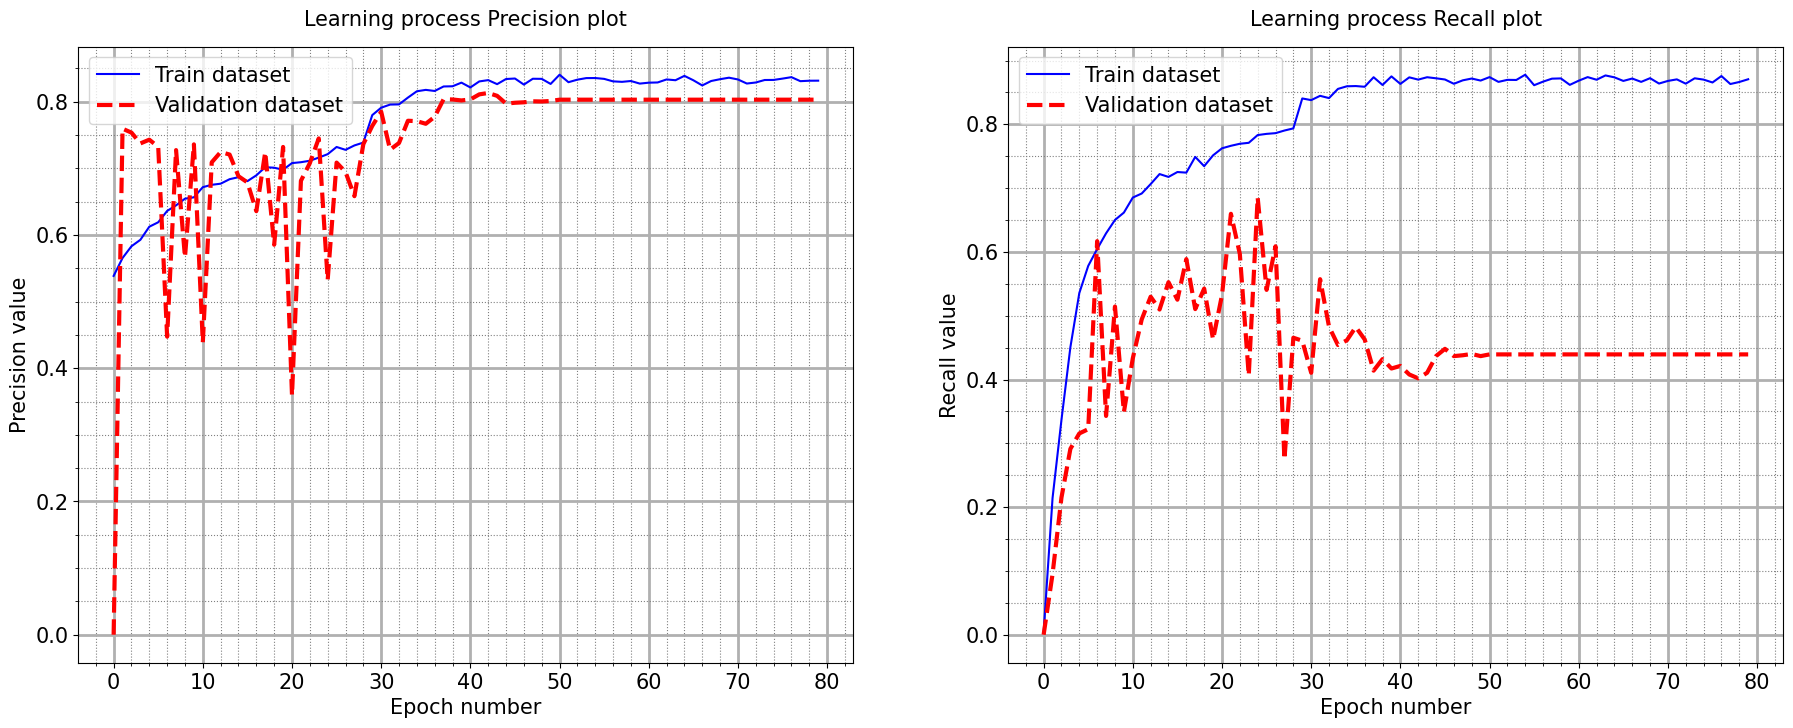

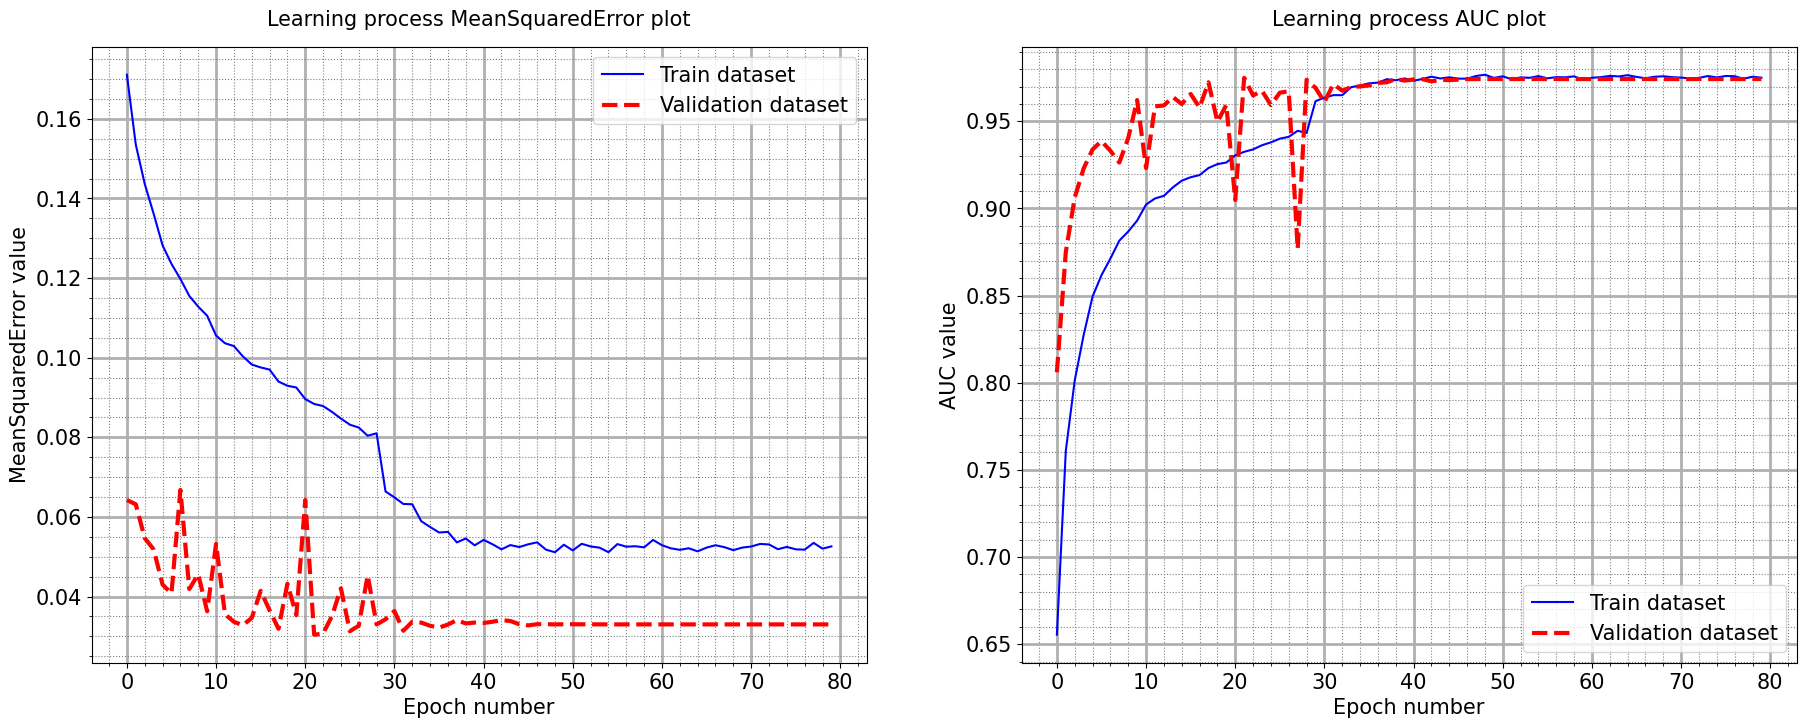

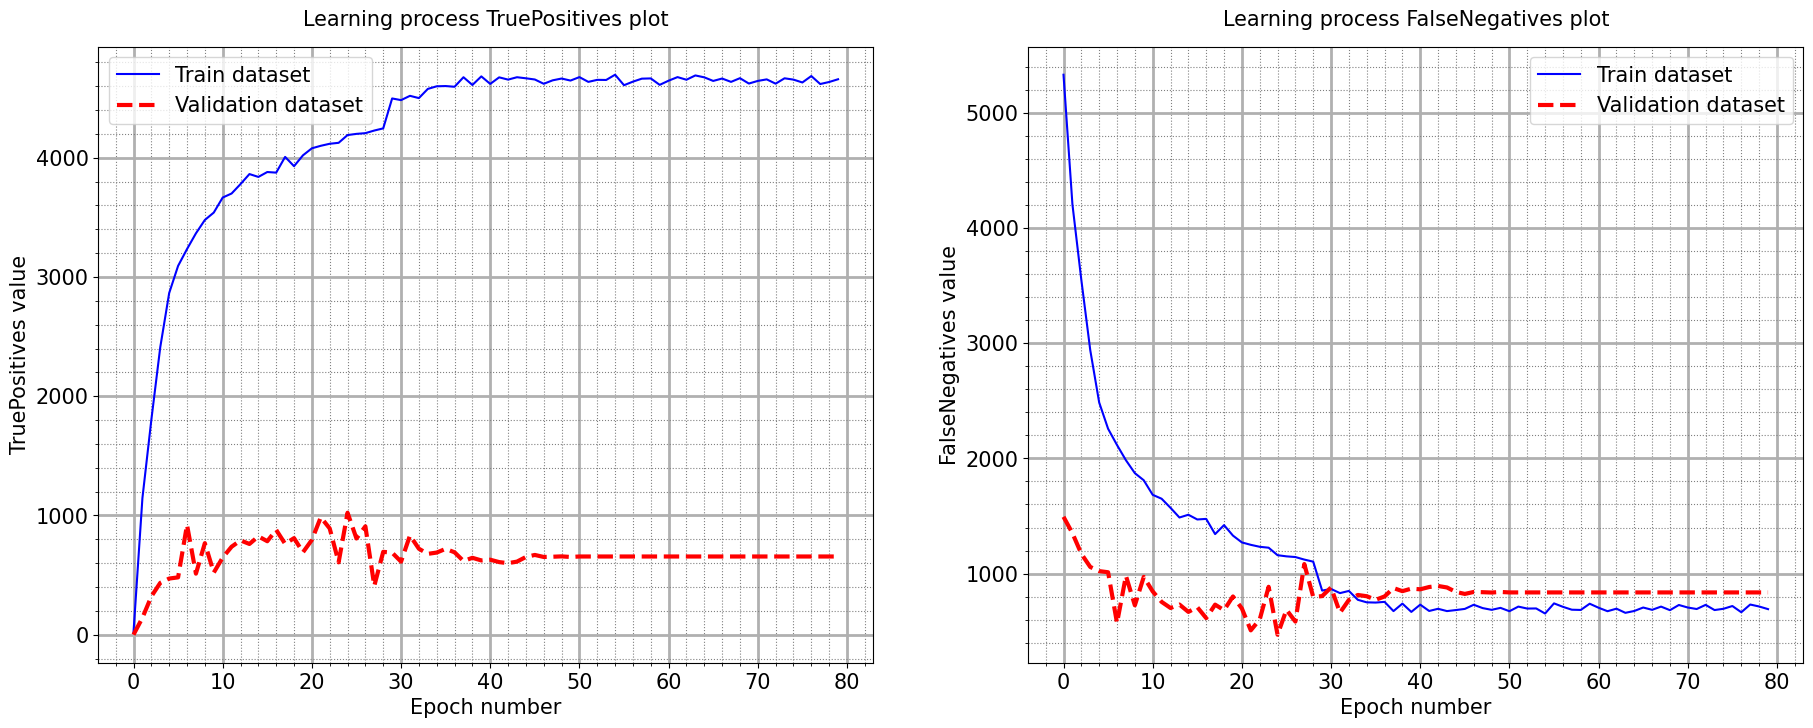

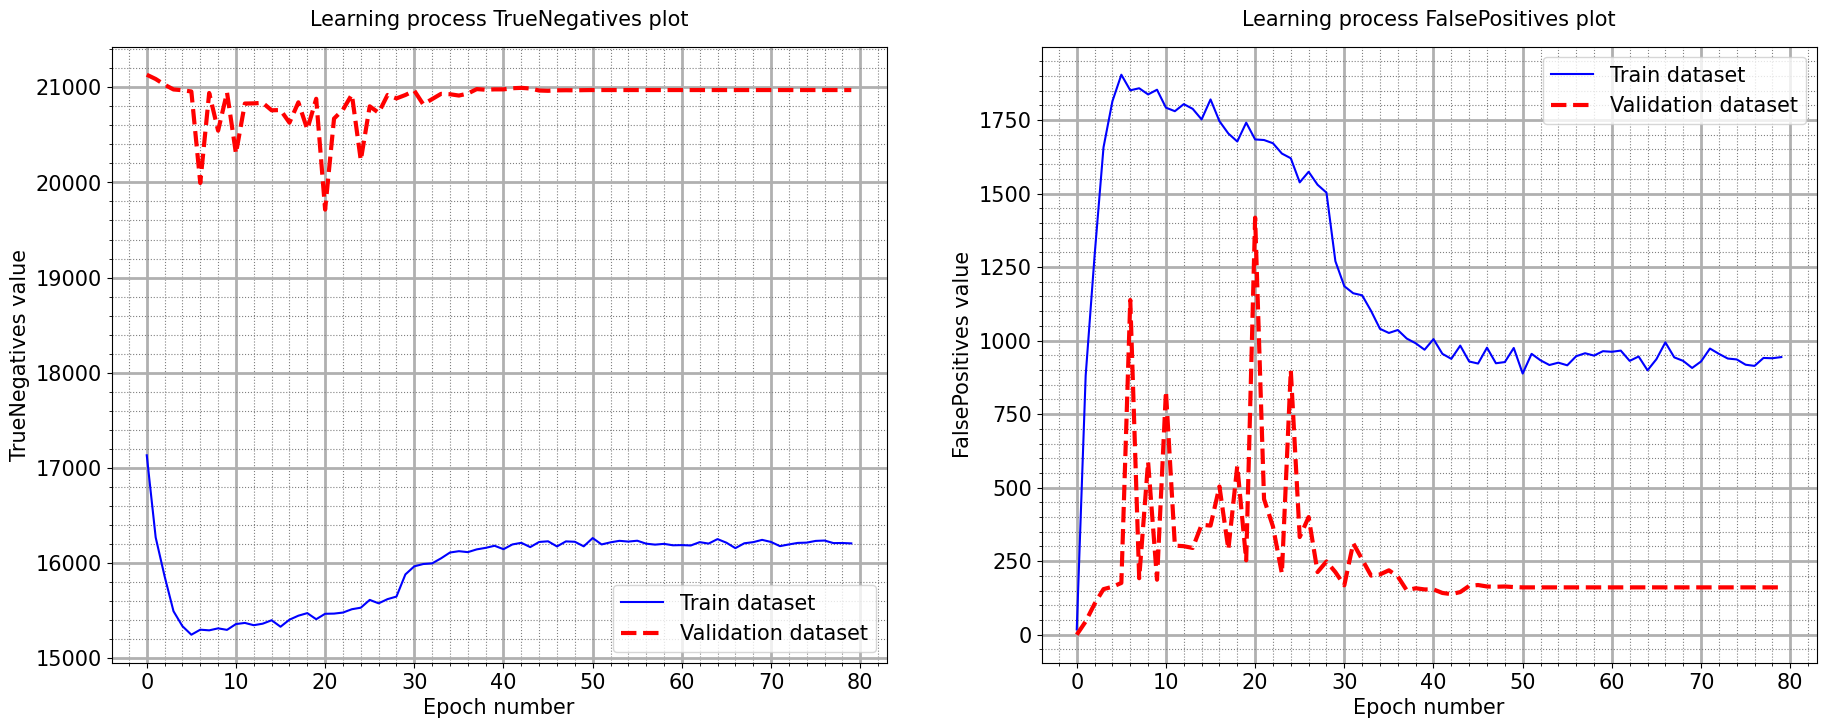

In [9]:
FONT_SIZE = 15
for key1,key2 in zip(['BinaryAccuracy','Precision','MeanSquaredError','TruePositives','TrueNegatives'],
                     ['loss','Recall','AUC','FalseNegatives','FalsePositives']):
    fig, axes = plt.subplots(1,2)

    fig.set_figwidth(22)
    fig.set_figheight(8)
    
    axes[0].plot(learn_df[key1], 
             label='Train dataset',  linewidth=1.5, color='blue')
    axes[0].plot(learn_df[f'val_{key1}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    axes[0].set_xlabel('Epoch number', fontsize=FONT_SIZE)
    axes[0].set_ylabel(f'{key1} value', fontsize=FONT_SIZE)
    axes[0].set_title(f"Learning process {key1} plot", fontsize=FONT_SIZE, pad=15)
    axes[0].tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    axes[0].minorticks_on()
    axes[0].grid(which='major', linewidth=2)
    axes[0].grid(which='minor', color = 'gray', linestyle = ':')
    axes[0].legend(fontsize = FONT_SIZE, facecolor = "white")

    axes[1].plot(learn_df[key2], 
             label='Train dataset',  linewidth=1.5, color='blue')
    axes[1].plot(learn_df[f'val_{key2}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    axes[1].set_xlabel('Epoch number', fontsize=FONT_SIZE)
    axes[1].set_ylabel(f'{key2} value', fontsize=FONT_SIZE)
    axes[1].set_title(f"Learning process {key2} plot", fontsize=FONT_SIZE, pad=15)
    axes[1].tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    axes[1].minorticks_on()
    axes[1].grid(which='major', linewidth=2)
    axes[1].grid(which='minor', color = 'gray', linestyle = ':')
    axes[1].legend(fontsize = FONT_SIZE, facecolor = "white")

    plt.show()

In [ ]:
'''for name in os.listdir(PATH_TO_MODEL):
    res = re.match(F'(id=v{MODEL_VER}n{MODEL_NUM}).*', name)
    if not res is None:
        PATH_TO_MODEL += '/' + res[0]
        break
dataset_desc = {'test': (DatasetPartDescription(PATH_TO_DATA['run_2'],DataCrop(0,40,MAX_VAL,MAX_VAL),SlidingCrop(CROP_SIZE,CROP_SIZE),XSHIFT),)}'''

In [ ]:
'''#входные и выходные данные
# reading
dataset = {'train': dict(zip(['x','y','bin'], [np.array(list(gen)) for gen in chain_dataset_gens(dataset_desc['train'])]))}

# displaying
logger.debug('Dataset')
for dataset_part_name, dataset_part in dataset.items():
    logger.debug('|'*8+dataset_part_name+'|'*8)
    for data_part_name, data_part in dataset_part.items():
        logger.debug(f'{data_part_name}.shape: {data_part.shape}')'''

In [ ]:
'''#выборка данных
# show parts took for learning
all_rects = {'run_1': {'test':None}, 
             'run_2': {'test':None}}
rects_colors = {'test':'yellow'}

for run_name in all_rects.keys():
    x_df, y_df = dw.get_x_and_y_data(*PATH_TO_DATA[run_name])
    x_df = None
    y_df = dw.roll_df(y_df, XSHIFT, 1)
    for dataset_part_name in all_rects[run_name].keys():
        # get all DatasetPartDescription for train, val or test
        dataset_part_desc = dataset_desc[dataset_part_name]
        # get all DatasetPartDescription for current run_name (run_1 or run_2)
        dataset_part_desc = [dataset_part for dataset_part in dataset_part_desc if re.findall(r'run_\d', dataset_part.data_path_tuple[0])[0] == run_name]
        # put rects list to all_rects[run_name][dataset_part_name]
        all_rects[run_name][dataset_part_name] = [Rectangle((dataset_part.file_data_crop.left, dataset_part.file_data_crop.top), 
                           dataset_part.file_data_crop.width, dataset_part.file_data_crop.height, 
                           facecolor=rects_colors[dataset_part_name], alpha=0.5) for dataset_part in dataset_part_desc]
    res_rects = list(itertools.chain(*[run_rects for run_rects_name, run_rects in all_rects[run_name].items()]))
    if res_rects:
        dw.draw_defects_map_with_rectangles_owerlap(y_df, res_rects, title = f'The parts took for learning from run_1 (red - train, green - validate, other - test)')'''

In [ ]:
'''# Загрузка модели
load_model = keras.models.load_model(PATH_TO_MODEL)
CROP_SIZE = load_model.inputs[0].shape[1]
CROP_STEPS = [CROP_SIZE, CROP_SIZE//2, CROP_SIZE//4]'''

In [ ]:
'''# тест модели
res_list = list()
for crop_step in CROP_STEPS:
    (test_x_time_gen, 
     test_x_amp_gen, 
     test_y_binary_gen,
     test_y_depth_gen) = get_dataset_gen(PATH_TO_DATA[f'run_{run}'], XSHIFT, DataCrop(None,None,None,200), CROP_SIZE, 20)
    
    test_x_time = np.stack([crop for crop in test_x_time_gen])
    test_x_amp = np.stack([crop for crop in test_x_amp_gen])
    test_y_binary = np.array([binary for binary in test_y_binary_gen])
    test_y_depth = np.array([depth for depth in test_y_depth_gen])
    
    res = load_model.evaluate([test_x_time, test_x_amp], test_y_binary, batch_size = 32, return_dict=True)
    res_list.append({'res':res,'crop_size':CROP_SIZE,'crop_step':crop_step})'''

In [ ]:
'''for line in res_list:
    print(f'crop_size: {line["crop_size"]}')
    print(f'crop_size: {line["crop_step"]}')
    print(line['res'])
    print()'''